In [1]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder

def search_GU_pairs(seq):
    GU_counter=0
    for i, char in enumerate(seq[:7]):

        if char=='G':
            if seq[-1-i]=='T':
                GU_counter+=1
        elif char=='T':
            if seq[-1-i]=='G':
                GU_counter+=1
    return GU_counter

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_json('v5_BootstrappedFits_10Aug2021.json.zip')
df = df.dropna()

conds = [x for x in df.keys() if x.endswith('_redNorm_median')]
errs = [x for x in df.keys() if x.endswith('_redNorm_err')]
signal_median = [x for x in df.keys() if x.endswith('signal_median')]
signal_err = [x for x in df.keys() if x.endswith('signal_err')]

lib = pd.read_json('./data/fitted_variants/NNNlib2_with_NUPACK_DNA_preds.json.zip')
df = df.merge(lib,on='RefSeq')
df = df.loc[df['dG_37C']<5]
df = df.loc[df['dG_37C']>-15]
df = df.loc[df.n_clusters_signal>10]

df = df.loc[df['dG_37C_err']<.5]
df = df.loc[df.series=='WC']

df['GT_count'] = df.apply(lambda row: search_GU_pairs(row['RefSeq']),axis=1)

df = df.loc[df['GT_count']<2]
df['TargetStruct'] = ['('*int((len(x)-4)/2)+'....'+')'*int((len(x)-4)/2) for x in df['RefSeq']]


ValueError: Expected object or value

<ErrorbarContainer object of 3 artists>

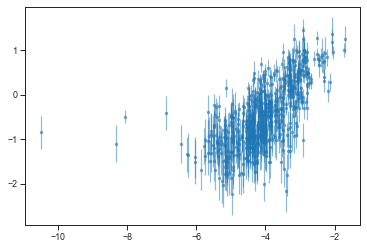

In [4]:
errorbar(df['dG_37C_NUPACK'],df['dG_37C'],yerr=df['dG_37C_err'], alpha=0.5,fmt='.')


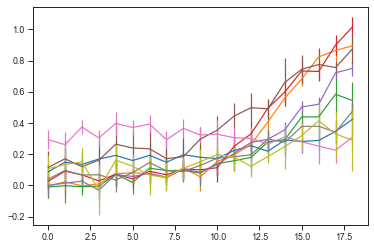

In [5]:
tmp = df.loc[df.dG_37C_NUPACK<-5.9]
for _ , row in tmp.iterrows():

    errorbar(range(19),row[conds].values, yerr=row[errs].values)

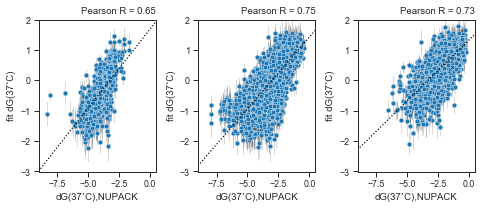

In [17]:
figure(figsize=(9,3))
from eternabench.plot import corrfunc
for x in range(3):
    tmp = df.loc[df.GT_count==x]
    
    subplot(1,4,x+1)
    errorbar(tmp['dG_37C_NUPACK'], tmp['dG_37C'], yerr=tmp['dG_37C_err'],color='k',zorder=0,fmt='.',alpha=0.3,linewidth=0.5)
    sns.scatterplot(x='dG_37C_NUPACK',y='dG_37C',data=tmp)
    xlim([-9,0.5])
    ylim([-3,2])

    xlabel('dG(37˚C),NUPACK')
    ylabel('fit dG(37˚C)')
    corrfunc(tmp['dG_37C_NUPACK'], tmp['dG_37C'], draw_line=True, method='pearson')
    
    
tight_layout()
savefig('Figures/GT_mismatch_12Aug2021.pdf',bbox_inches='tight')

In [6]:
def get_feature_list(row, stack_size=1):
    seq = 'x'*stack_size+row['RefSeq']+'y'*stack_size
    struct = '('*stack_size+row['TargetStruct']+')'*stack_size # has one more stack at the end
    
    loops = LoopExtruder(seq, struct, neighbor_bps=stack_size-1)
    stacks = StackExtruder(seq, struct, stack_size=stack_size)
    
    loops_cleaned = [x.split(',')[0].replace(' ','_') for x in loops]
    stacks_cleaned = [x.split(',')[0].replace(' ','_') for x in stacks[:-1]]
    
    return loops_cleaned+stacks_cleaned

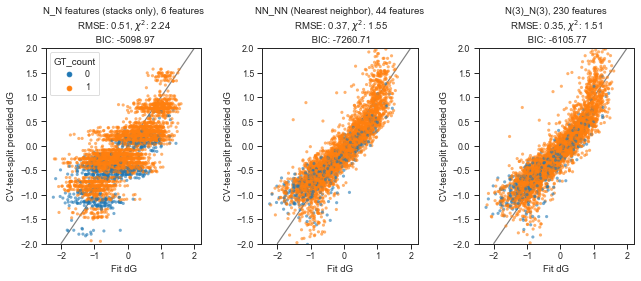

In [40]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

figure(figsize=(12,4))

N_SPLITS = 5
y = df.dG_37C
y_err = df.dG_37C_err

titles = ['N_N features (stacks only)', 'NN_NN (Nearest neighbor)', 'N(3)_N(3)', 'N(4)_N(4)', 'N(5)_N(5)']

coef_dfs=[]
for n_features in range(3):
    
    #Write dataframe of feature counts
    
    df['feature_list'] = df.apply(lambda row: get_feature_list(row, stack_size=n_features+1), axis=1)
    
    cv = CountVectorizer()
    feats = pd.DataFrame.sparse.from_spmatrix(cv.fit_transform([' '.join(x) for x in df['feature_list']]),
                    index=df.index, columns=[x.upper() for x in cv.get_feature_names()])
    
    # Remove features that every construct contains
    for k in feats.keys():
        if len(feats[k].unique())==1:
            feats = feats.drop(columns=[k])
            
    tot_features = len(feats.keys())
            
    #Perform linear regression fit
    mdl = Ridge(fit_intercept=False)

    X = feats.values

    results = cross_validate(mdl, X, y, cv=N_SPLITS, return_estimator=True)
    coef_df = pd.DataFrame()
    for x in results['estimator']:
        for i in range(len(feats.columns)):
            coef_df = coef_df.append({'coef': feats.columns[i], 'weight': x.coef_[i]}, ignore_index=True)
    coef_dfs.append(coef_df)
    subplot(1,4,n_features+1)

    preds = cross_val_predict(mdl, X, y, cv=N_SPLITS)
    
    df['tmp_pred'] = preds
    
    #errorbar(y, preds, xerr=y_err, fmt='.', alpha=0.1,zorder=0, color='k')
    sns.scatterplot(x='dG_37C', y='tmp_pred', data=df, hue='GT_count', linewidth=0, s=10, alpha=0.6, palette='tab10')
    xlabel('Fit dG')
    ylabel('CV-test-split predicted dG')
    n = len(df)
    rss = np.sum(np.square(y - preds))
    bic = n*np.log(rss/n) + tot_features*np.log(n) 
    aic = n*np.log(rss/n) + 2*tot_features
    rmse = np.sqrt(np.mean(np.square(y - preds)))
    chi2 = np.sqrt(np.mean(np.square(y - preds)/np.square(y_err)))
    title("%s, %d features\n RMSE: %.2f, $\chi^2$: %.2f \n BIC: %.2f" % (titles[n_features], tot_features, rmse, chi2,bic))
    
    plot([-2,2],[-2,2],color='grey',zorder=0)
    ylim([-2,2])
    if n_features!=0: legend([],frameon=False)

tight_layout()
savefig('NN_model_testing_WC_scatter_GT1.pdf', bbox_inches='tight')
savefig('NN_model_testing_WC_scatter_GT1.png', dpi=300, bbox_inches='tight')

In [46]:
df.sort_values('tmp_pred',ascending=False)[['RefSeq','tmp_pred']].iloc[:20]

,RefSeq,tmp_pred
6284,TATTAGAAATAGTA,2.582941
15943,TAGTAGAAATATTA,2.356279
13563,TATAAGAAATTGTA,2.214820
965,ATTAAGAAATTGAT,2.211366
4307,AAGTAGAAATATTT,2.151543
4727,TTATAGAAATATGA,2.118963
14189,AAAGAGAAATTTTT,2.081234
6755,ATTGAGAAATTAAT,2.070939
10872,TATGAGAAATTATA,2.062155
4112,TAAAGGAAATTTTA,2.057531


In [47]:
# Getting the NUPACK parameters
N_SPLITS = 5
y = df.dG_37C_NUPACK

coef_dfs_NUPACK=[]
for n_features in range(2):
    
    #Write dataframe of feature counts
    
    df['feature_list'] = df.apply(lambda row: get_feature_list(row, stack_size=n_features+1), axis=1)
    
    cv = CountVectorizer()
    feats = pd.DataFrame.sparse.from_spmatrix(cv.fit_transform([' '.join(x) for x in df['feature_list']]),
                    index=df.index, columns=[x.upper() for x in cv.get_feature_names()])

    # Remove features that every construct contains
    for k in feats.keys():
        if len(feats[k].unique())==1:
            feats = feats.drop(columns=[k])
            
    tot_features = len(feats.keys())
            
    #Perform linear regression fit
    mdl = Ridge(fit_intercept=False)

    X = feats.values

    results = cross_validate(mdl, X, y, cv=N_SPLITS, return_estimator=True)
    coef_df = pd.DataFrame()
    for x in results['estimator']:
        for i in range(len(feats.columns)):
            coef_df = coef_df.append({'coef': feats.columns[i], 'weight': x.coef_[i]}, ignore_index=True)
    coef_dfs_NUPACK.append(coef_df)

In [35]:
NN_ordering = ['AA_TT', 'AC_GT', 'AG_CT', 'AT_AT', 'CA_TG', 'CC_GG',
       'CG_CG', 'CT_AG', 'GA_TC', 'GC_GC', 'GG_CC',  'GT_AC',
       'TA_TA', 'TC_GA', 'TG_CA',  'TT_AA', 'AGAAAT','CGAAAG', 'GGAAAC', 'TGAAAA', 'XA_TY', 'XC_GY',
       'XG_CY', 'XT_AY']

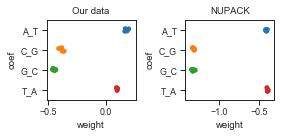

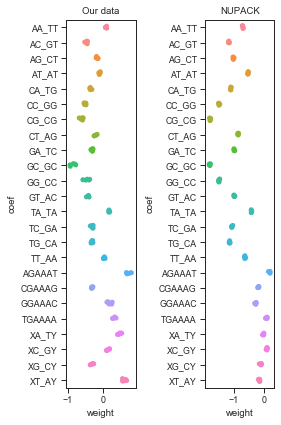

In [37]:
figure(figsize=(4,2))
subplot(1,2,1)
sns.stripplot(x='weight', y='coef', data=coef_dfs[0])
title('Our data')
subplot(1,2,2)
title('NUPACK')
sns.stripplot(x='weight', y='coef', data=coef_dfs_NUPACK[0])
tight_layout()
#savefig('coefs_0_mdl.pdf',bbox_inches='tight')
figure(figsize=(4,6))
subplot(1,2,1)
title('Our data')
sns.stripplot(x='weight', y='coef', data=coef_dfs[1], order=NN_ordering)

subplot(1,2,2)
title('NUPACK')
sns.stripplot(x='weight', y='coef', data=coef_dfs_NUPACK[1], order=NN_ordering)
tight_layout()
savefig('coefs_1_mdl.pdf',bbox_inches='tight')
savefig('coefs_1_mdl.png',dpi=300, bbox_inches='tight')

44


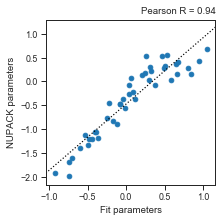

In [54]:
figure(figsize=(3,3))

n_params = int(len(coef_dfs[1])/5)
print(n_params)
scatter(coef_dfs[1]['weight'].values[:n_params], coef_dfs_NUPACK[1]['weight'].values[:n_params])

corrfunc(coef_dfs[1]['weight'].values[:n_params], coef_dfs_NUPACK[1]['weight'].values[:n_params], draw_line=True, method='pearson')

tight_layout()
xlabel('Fit parameters')
ylabel('NUPACK parameters')

savefig('NUPACK_vs_manifold_NN_parameters_GT_mismatches.pdf',bbox_inches='tight')

In [57]:
len(df)

3813

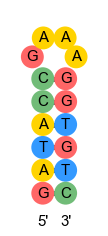

In [60]:
from ipynb.draw import draw_struct

figure(figsize=(4,4))
ax=gca()
draw_struct(df.iloc[0]['RefSeq'], '((((((....))))))',ax=ax)
savefig('tmp_wc.pdf',bbox_inches='tight')

In [ ]:
from RiboGraphViz import RGV

test_struct =  '...((((..(((....(((...)))..)))..(((...)))....))))...'
rgv = RGV(test_struct)

rgv.draw()